In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import random
import os 
import imageio 
from IPython.display import Image
import pandas as pd
import csv
from scipy.stats import shapiro, t
import plotly.express as px
from scipy import stats
import time

In [2]:
# Define the parameters
xmin, xmax, ymin, ymax = -2.0, 1.0, -1.5, 1.5
i_max = 200
s_values = [10, 500, 1000, 1500]
num_runs = 10

def calculate_reference_areas(xmin, xmax, ymin, ymax, i_max, s_values, num_runs):
    reference_areas = np.zeros((len(s_values), num_runs))
    for run in range(num_runs):
#         print(f"Run {run + 1}/{num_runs}")
        seed = run 
        np.random.seed(run)
        for idx, s in enumerate(s_values):
            reference_s = s
            reference_i_max = i_max
            reference_area = 0.0
            for _ in range(reference_s):
                x = np.random.uniform(xmin, xmax)
                y = np.random.uniform(ymin, ymax)
                c = complex(x, y)
                z = c
                for _ in range(reference_i_max):
                    if abs(z) > 2.0:
                        break
                    z = z * z + c
                else:
                    reference_area += 1
            reference_area = (reference_area / reference_s) * (xmax - xmin) * (ymax - ymin)
            reference_areas[idx, run] = reference_area
#             print(f"Reference Area for Run {run + 1}: {reference_area}, s: {s}")
    return reference_areas

def calculate_area_estimations(xmin, xmax, ymin, ymax, i_max, s_values, num_runs, reference_areas):
    area_estimations_sum = np.zeros((i_max, len(s_values), num_runs))

    for run in range(num_runs):
#         print(f"Run {run + 1}/{num_runs}")
        seed = run
        np.random.seed(run)
        for idx, s in enumerate(s_values):
            for j in range(1, i_max + 1):
                AM = 0.0
                for _ in range(s):
                    x = np.random.uniform(xmin, xmax)
                    y = np.random.uniform(ymin, ymax)
                    c = complex(x, y)
                    z = c
                    for _ in range(j):
                        if abs(z) > 2.0:
                            break
                        z = z * z + c
                    else:
                        AM += 1
                AM = (AM / s) * (xmax - xmin) * (ymax - ymin)
                area_estimations_sum[j - 1, idx, run] = AM
    return area_estimations_sum

# Calculate reference areas
reference_areas = calculate_reference_areas(xmin, xmax, ymin, ymax, i_max, s_values, num_runs)

# Calculate area estimations
area_estimations_sum = calculate_area_estimations(xmin, xmax, ymin, ymax, i_max, s_values, num_runs, reference_areas)

# Calculate the reference area averages for each 's' value
reference_areas_avg = np.mean(reference_areas, axis=1)
print(reference_areas_avg)

[1.62   1.5228 1.5183 1.5312]


In [3]:
# Define parameters
t_value = t.ppf(1 - 0.025, num_runs - 1)

# Create lists to store results
data = {'i': [], 's': [], 'Estimated Area': [], 'Confidence Interval': []}

# Loop over 'i' values
for i in range(5, i_max + 1, 5):  # Save every 10 iterations
    # Loop over 's' values
    for idx, s in enumerate(s_values):
        # Calculate the mean and standard deviation for the confidence interval
        mean_estimation = np.mean(area_estimations_sum[i - 1, idx, :])
        std_estimation = np.std(area_estimations_sum[i - 1, idx, :], ddof=1)

        # Calculate the confidence interval
        margin_of_error = t_value * (std_estimation / np.sqrt(num_runs))
        confidence_interval = (mean_estimation - margin_of_error, mean_estimation + margin_of_error)

        # Append data to lists
        data['i'].append(i)
        data['s'].append(s)
        data['Estimated Area'].append(round(mean_estimation, 5))
        data['Confidence Interval'].append((round(confidence_interval[0], 5), round(confidence_interval[1], 5)))

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('confidence_intervals.csv', index=False)

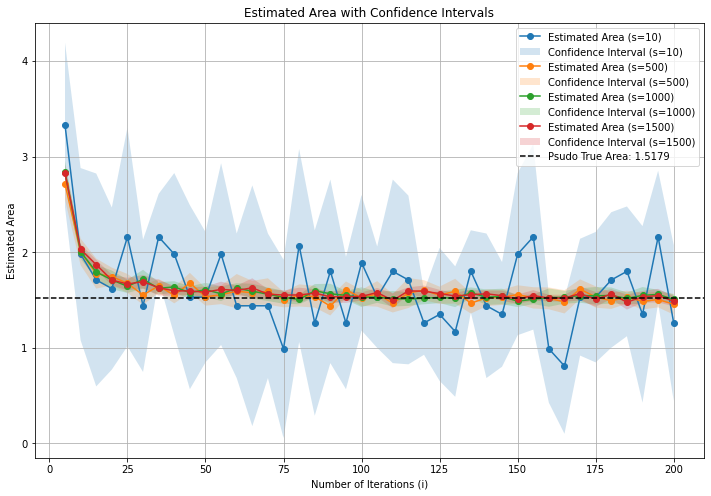

In [4]:
# Convert 'Confidence Interval' to numeric
df['Confidence Interval'] = df['Confidence Interval'].apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Plotting the estimated area, reference area, and confidence intervals with shaded areas
plt.figure(figsize=(12, 8))

for s in s_values:
    data_s = df[df['s'] == s]
    
    # Plot the estimated area
    plt.plot(data_s['i'], data_s['Estimated Area'], label=f'Estimated Area (s={s})', marker='o')
    
    # Shade the area between the confidence intervals
    plt.fill_between(data_s['i'], data_s['Confidence Interval'].apply(lambda x: x[0]),
                     data_s['Confidence Interval'].apply(lambda x: x[1]), alpha=0.2,
                     label=f'Confidence Interval (s={s})')

# Add a horizontal line for the reference area
plt.axhline(y=1.5179062500000002, color='k', linestyle='--', label=f'Psudo True Area: {1.5179062500000002:.4f}')

plt.xlabel('Number of Iterations (i)')
plt.ylabel('Estimated Area')
plt.title('Estimated Area with Confidence Intervals')
plt.legend()
plt.grid()
plt.show()

In [5]:
# Reshape reference areas to ensure compatibility
reshaped_reference_areas = reference_areas_avg[:, np.newaxis]

# Calculate the absolute error for pure random sampling method
error_random = np.abs(area_estimations_sum - reshaped_reference_areas)

# Calculate mean and standard deviation for pure random sampling
mean_error_random = np.mean(error_random, axis=2)
std_error_random = np.std(error_random, axis=2, ddof=1)

# Define parameters
t_value = t.ppf(1 - 0.025, num_runs - 1)

# Create lists to store results
data_error_random = {'i': [], 's': [], 'Absolute Error': [], 'Confidence Interval': []}

# Loop over 'i' values
for i in range(5, i_max + 1, 5):  # Save every 10 iterations
    # Loop over 's' values
    for idx, s in enumerate(s_values):
        # Calculate mean and standard deviation for the absolute error
        mean_abs_error = np.mean(mean_error_random[i - 1, idx])
        std_abs_error = np.std(error_random[i - 1, idx], ddof=1)

        # Calculate the confidence interval for the absolute error
        margin_of_error_abs = t_value * (std_abs_error / np.sqrt(num_runs))
        confidence_interval_abs = (mean_abs_error - margin_of_error_abs, mean_abs_error + margin_of_error_abs)

        # Append data to lists
        data_error_random['i'].append(i)
        data_error_random['s'].append(s)
        data_error_random['Absolute Error'].append(round(mean_abs_error, 4))
        data_error_random['Confidence Interval'].append((round(confidence_interval_abs[0], 4), round(confidence_interval_abs[1], 4)))

# Create a DataFrame for absolute error with pure random sampling
df_error_random = pd.DataFrame(data_error_random)

# Save to CSV for absolute error with pure random sampling
df_error_random.to_csv('confidence_intervals_absolute_error_random2.csv', index=False)

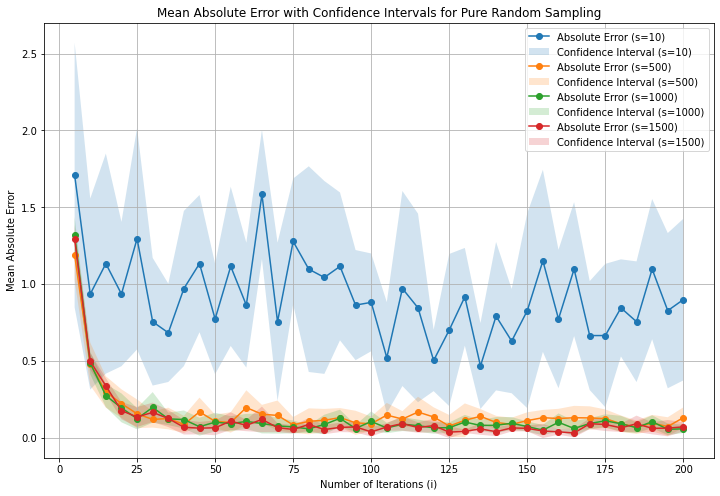

In [6]:
# Convert 'Confidence Interval' to numeric
df_error_random['Confidence Interval'] = df_error_random['Confidence Interval'].apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Plotting the estimated area and confidence intervals with shaded areas
plt.figure(figsize=(12, 8))

for s in s_values:
    data_s = df_error_random[df_error_random['s'] == s]
    
    # Plot the estimated area
    plt.plot(data_s['i'], data_s['Absolute Error'], label=f'Absolute Error (s={s})', marker='o')
    
    # Shade the area between the confidence intervals
    plt.fill_between(data_s['i'], data_s['Confidence Interval'].apply(lambda x: x[0]),
                     data_s['Confidence Interval'].apply(lambda x: x[1]), alpha=0.2,
                     label=f'Confidence Interval (s={s})')

plt.xlabel('Number of Iterations (i)')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error with Confidence Intervals for Pure Random Sampling')
plt.legend()
plt.grid()
plt.show()